In [41]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# For OpenCV-based face detection
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
    Reshape
)
from tensorflow.keras.layers import multiply

from sklearn.model_selection import train_test_split
# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Imported all relevent libraries 
# Loading face data 

#read in image data

In [42]:
# Path to your Haar Cascade XML file
#HAAR_CASCADE_PATH = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/haarcascade_frontalface_default.xml'
HAAR_CASCADE_PATH = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_PATH)

#EYE_CASCADE_PATH = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/haarcascade_eye.xml'
EYE_CASCADE_PATH = 'haarcascade_eye.xml'
eye_cascade = cv2.CascadeClassifier(EYE_CASCADE_PATH)
if eye_cascade.empty():
    raise IOError("Could not load Haar cascade for eyes.")

def detect_faces(pil_image, min_size=60):
    #Detect faces using Haar Cascade. Return a list of PIL Images for each face
    #that meets the minimum bounding box size.

    open_cv_image = np.array(pil_image.convert('RGB'))[:, :, ::-1]
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    faces_bboxes = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),          # or you can tweak this param as well
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    face_images = []
    for (x, y, w, h) in faces_bboxes:
        # Filter out partial faces by bounding box dimensions
        if w < min_size or h < min_size:
            # If bounding box is too small, skip
            continue
        
        # Crop the face region
        face_bgr = open_cv_image[y:y+h, x:x+w]
        face_pil = Image.fromarray(face_bgr[:, :, ::-1], mode='RGB')
        
        # Resize/crop to 170×170
        face_pil = face_pil.resize((170, 170), Image.Resampling.LANCZOS)
        
        face_images.append(face_pil)

    return face_images
      
def detect_faces_with_eye_check(pil_image, min_size=60, require_eyes=True):
    """
    Detect faces using Haar Cascade. Optionally require each detected face
    to have at least one eye detected within the bounding box.
    
    Args:
        pil_image: A PIL image.
        min_size (int): Minimum width/height of a face bounding box.
        require_eyes (bool): Whether to filter out bounding boxes with no eyes.
    
    Returns:
        face_images (list): A list of PIL Images (170x170).
    """
    # Convert PIL -> OpenCV format (BGR)
    open_cv_image = np.array(pil_image.convert('RGB'))[:, :, ::-1]
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    # Detect face bounding boxes
    faces_bboxes = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    face_images = []
    for (x, y, w, h) in faces_bboxes:
        # 1. Filter out if bounding box too small:
        if w < min_size or h < min_size:
            continue
        
        # 2. (Optional) Eye check: detect eyes within this face region
        if require_eyes:
            faceROI_gray = gray[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(faceROI_gray)
            
            # If no eyes detected, skip
            if len(eyes) == 0:
                continue
        
        # Crop the face region
        face_bgr = open_cv_image[y:y+h, x:x+w]
        face_pil = Image.fromarray(face_bgr[:, :, ::-1], mode='RGB')
        
        # Resize/crop to 170×170
        face_pil = face_pil.resize((170, 170), Image.Resampling.LANCZOS)
        
        face_images.append(face_pil)

    return face_images

def process_directory(directory):
    total_data = {'X': [], 'Y': [], 'raw': []}

    for filename in os.listdir(directory):
        if filename.startswith('.'):
            continue
        
        if filename.startswith('s'):
            label = 1  # Squint
        elif filename.startswith('us'):
            label = 0  # Not squint
        else:
            continue
        
        full_path = os.path.join(directory, filename)
        
        try:
            img = Image.open(full_path)
            
            # Use the new face+eye detection
            faces = detect_faces_with_eye_check(img, min_size=60, require_eyes=True)
            
            if len(faces) == 0:
                print(f"No valid (full) faces detected in {filename}. Skipping.")
                continue
            
            for face in faces:
                face_gray = face.convert('L')
                face_raw = np.array(face_gray)
                
                total_data['raw'].append(face_raw)
                
                face_flattened = face_raw.flatten()
                total_data['X'].append(face_flattened)
                total_data['Y'].append(label)
        
        except IOError:
            print(f"Cannot open image file: {filename}")

    if not total_data['X']:
        print("No valid images or faces found in directory.")
        return total_data

    # Pad flattened arrays to the same length
    max_len = max(len(x) for x in total_data['X'])
    X_padded = [np.pad(x, (0, max_len - len(x))) for x in total_data['X']]
    
    total_data['X'] = np.array(X_padded, dtype=np.float32)
    total_data['Y'] = np.array(total_data['Y'], dtype=np.int32)

    return total_data

def view_images(dict_obj, num_images):
    """
    Display up to n raw grayscale images (each 170x170).
    """
    num_to_show = min(num_images, len(dict_obj['raw']))
    for i in range(num_to_show):
        image_2d = dict_obj['raw'][i]
        plt.imshow(image_2d, cmap='gray')
        plt.title(f"Face {i} - Label {dict_obj['Y'][i]}")
        plt.show()

def plot_label_distribution(df):
    """
    Plots and prints the distribution of squint (1) vs. not squint (0) 
    in the given DataFrame. Assumes 'Y' is the label column.
    """
    # 1. Print counts and percentages
    label_counts = df['Y'].value_counts()
    label_percentages = df['Y'].value_counts(normalize=True) * 100

    print("Label Counts:")
    print(label_counts)
    print("\nLabel Percentages (%):")
    print(label_percentages)

    # 2. Plot the distribution
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Y', data=df, palette='viridis')
    ax.set_xticklabels(['Not Squint (0)', 'Squint (1)'])
    plt.title("Distribution of Squint vs. Not Squint")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

No valid (full) faces detected in s11.jpg. Skipping.
No valid (full) faces detected in s6.jpg. Skipping.
Total faces before cleaning: 139
Removed 0 rows that do not contain a valid face.
Total faces after cleaning: 139
                                                   X  Y  \
0  [84.0, 78.0, 79.0, 80.0, 79.0, 83.0, 82.0, 84....  1   
1  [143.0, 146.0, 149.0, 151.0, 156.0, 157.0, 157...  1   
2  [42.0, 48.0, 49.0, 44.0, 39.0, 52.0, 70.0, 67....  1   
3  [246.0, 246.0, 246.0, 246.0, 246.0, 246.0, 246...  1   
4  [44.0, 42.0, 46.0, 53.0, 62.0, 64.0, 61.0, 58....  1   

                                                 raw  
0  [[84, 78, 79, 80, 79, 83, 82, 84, 85, 85, 84, ...  
1  [[143, 146, 149, 151, 156, 157, 157, 156, 147,...  
2  [[42, 48, 49, 44, 39, 52, 70, 67, 45, 31, 23, ...  
3  [[246, 246, 246, 246, 246, 246, 246, 245, 244,...  
4  [[44, 42, 46, 53, 62, 64, 61, 58, 50, 41, 48, ...  


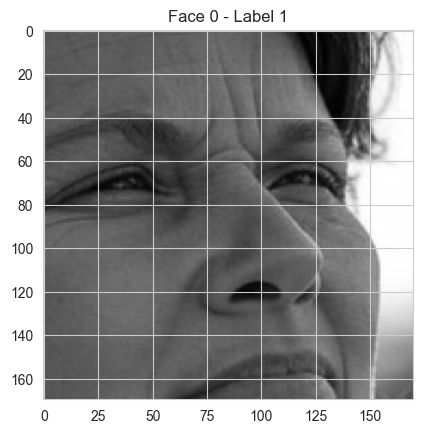

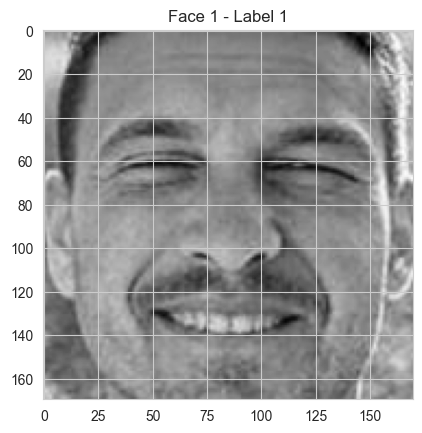

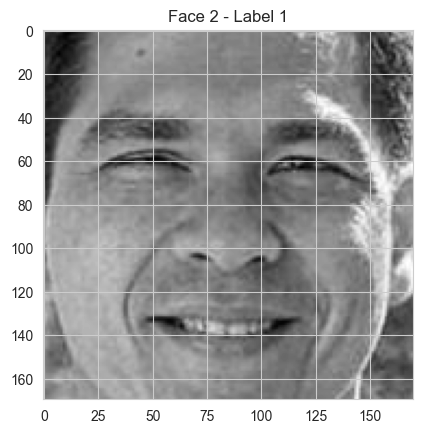

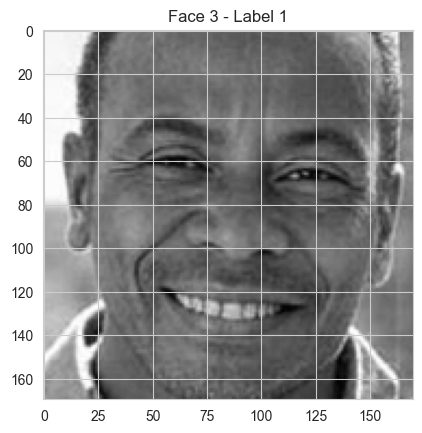

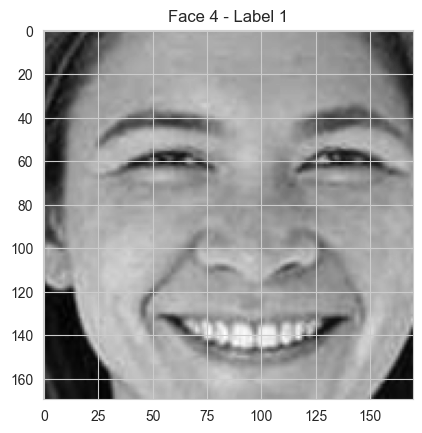

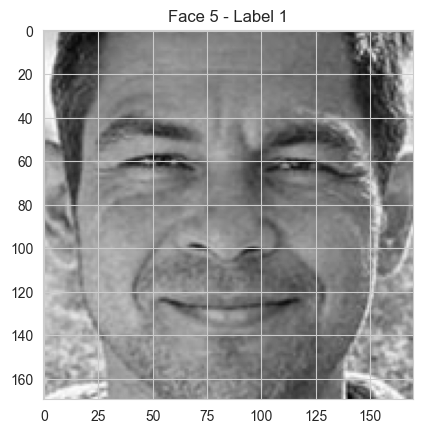

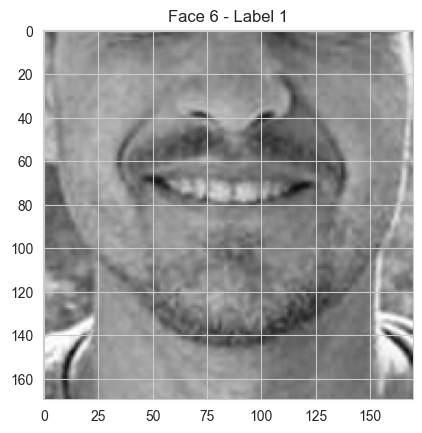

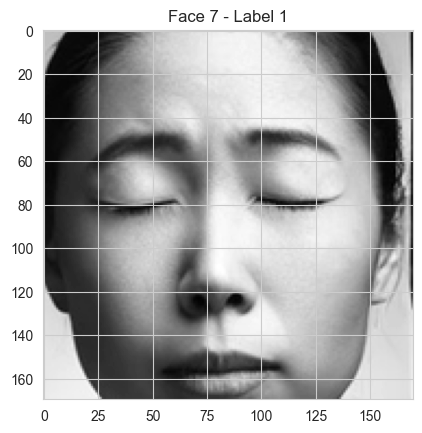

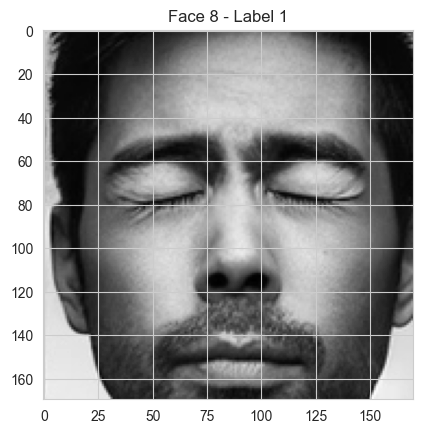

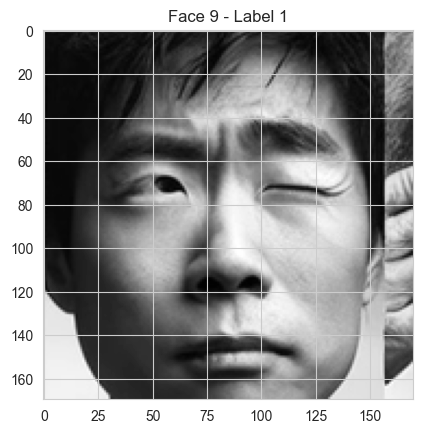

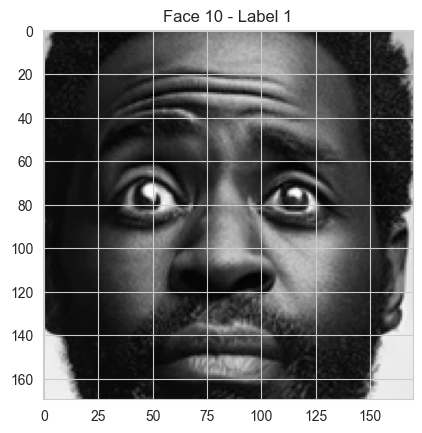

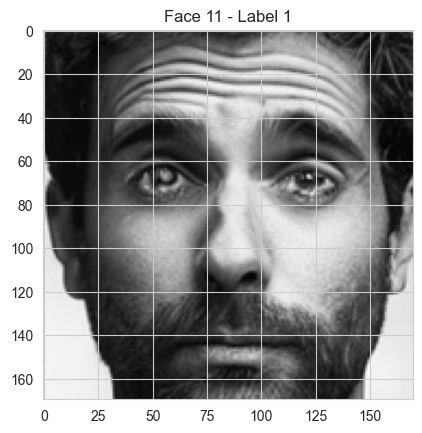

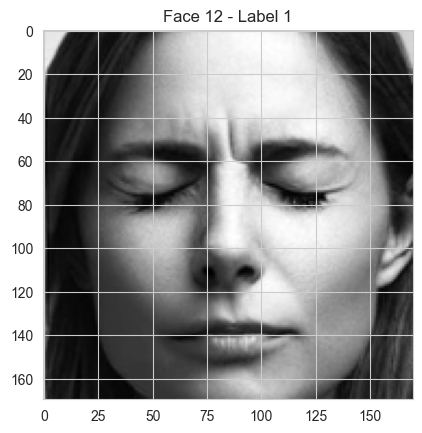

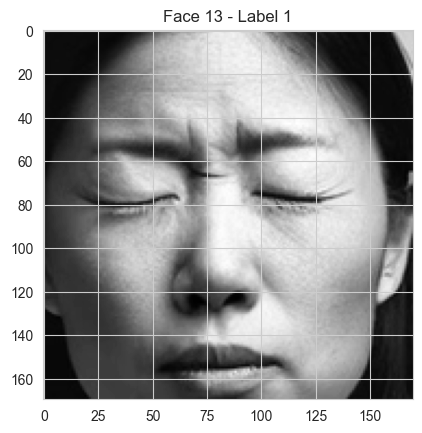

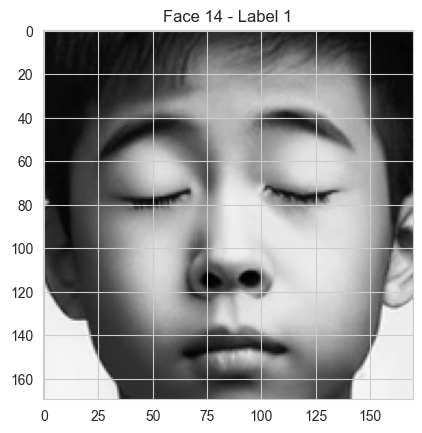

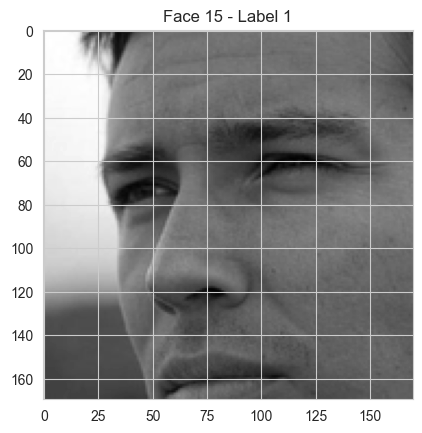

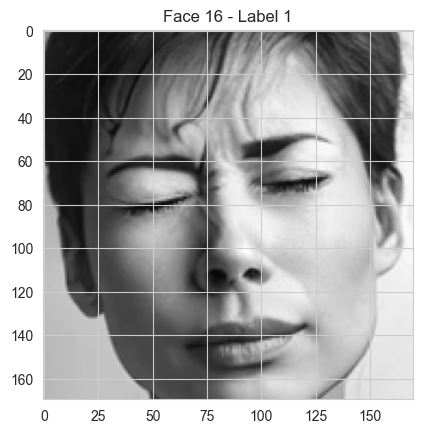

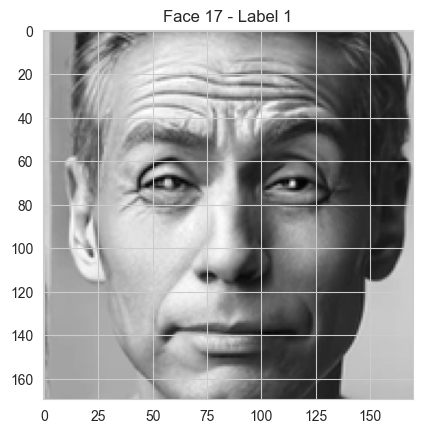

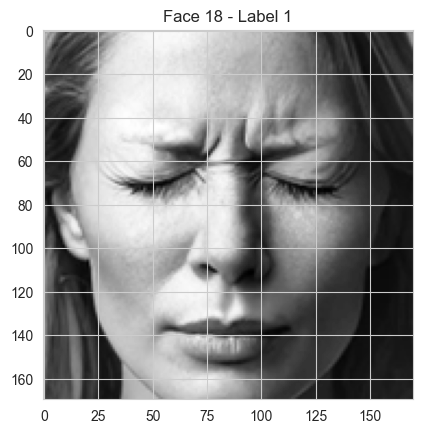

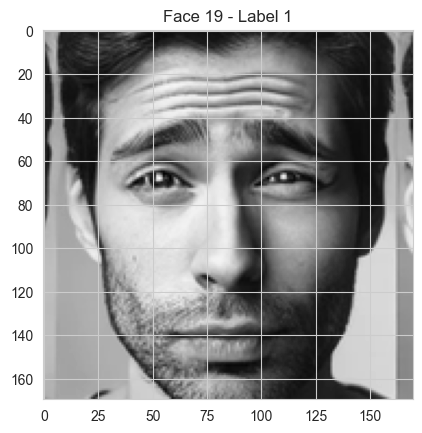

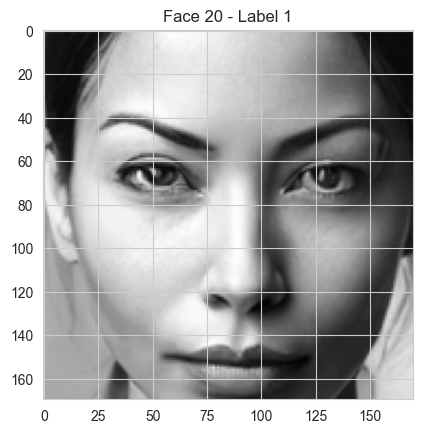

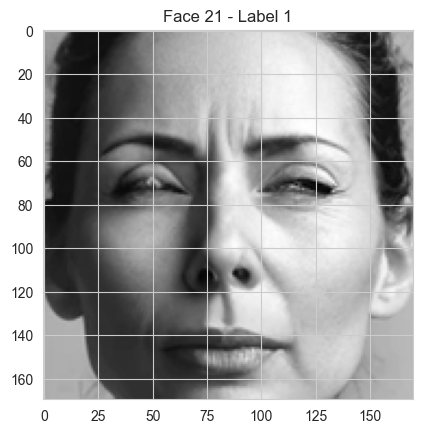

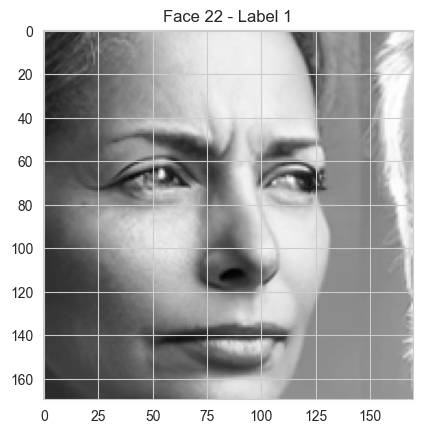

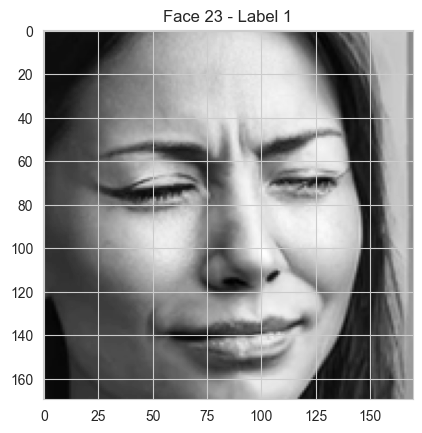

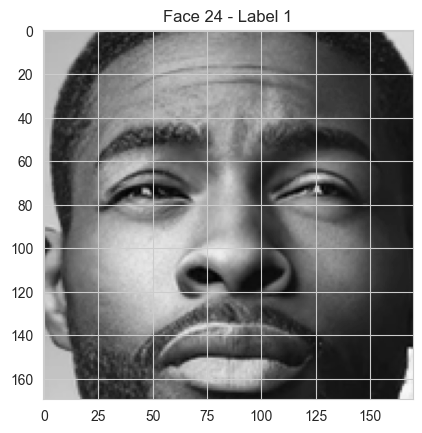

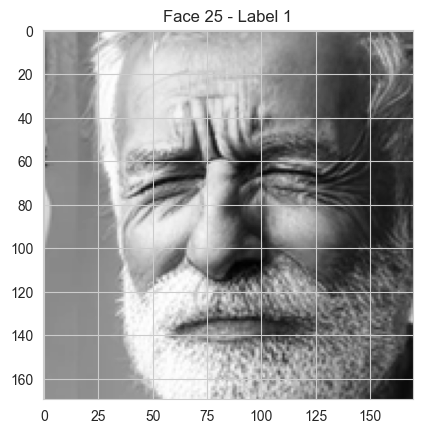

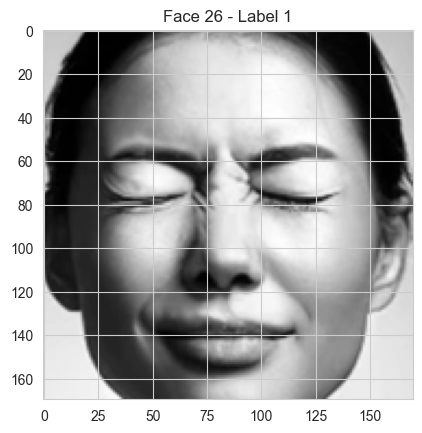

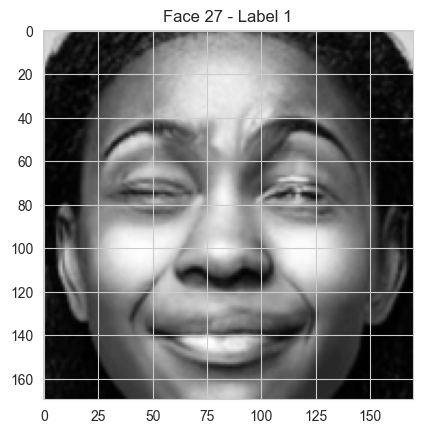

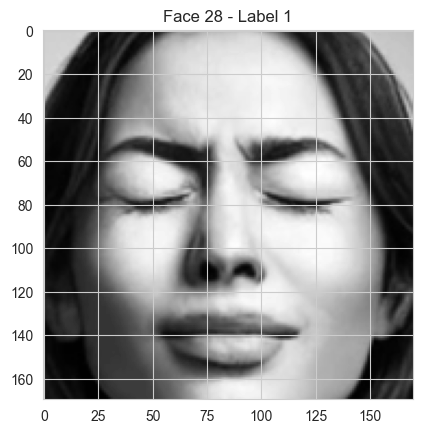

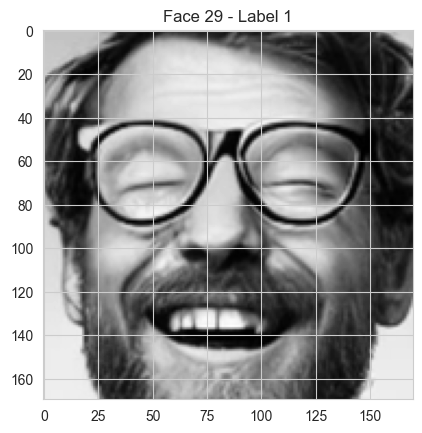

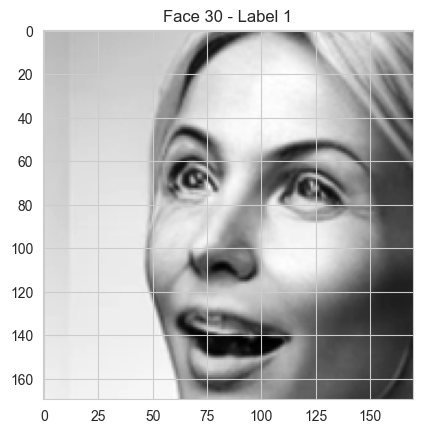

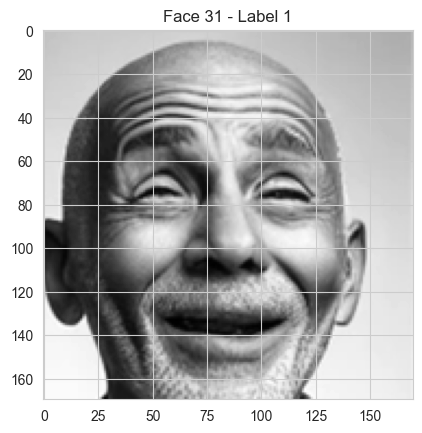

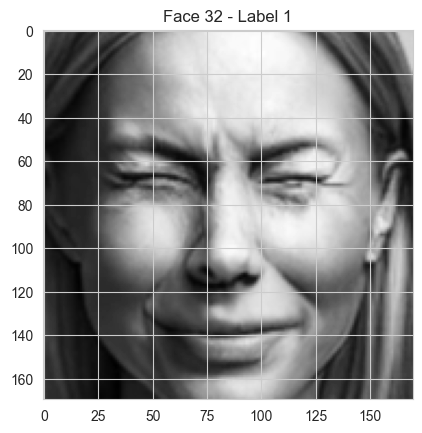

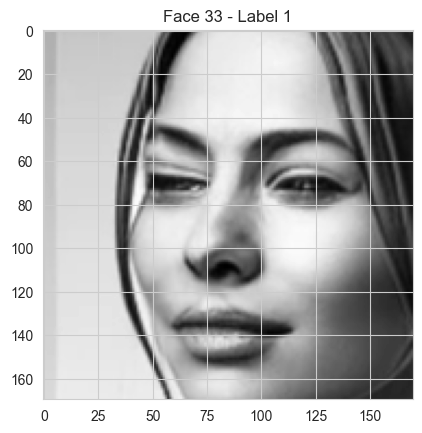

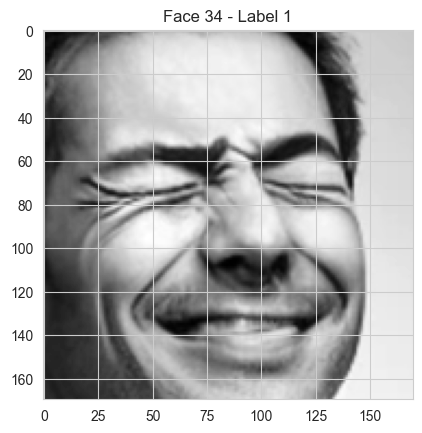

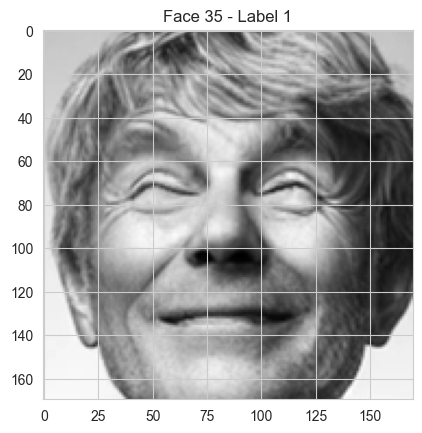

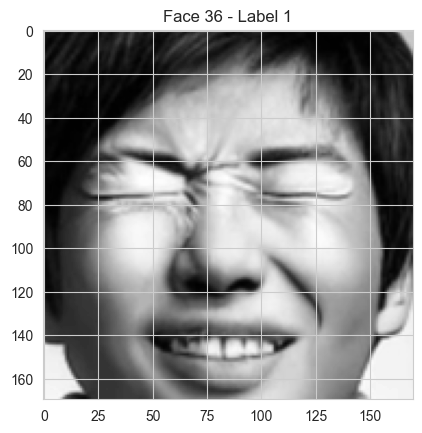

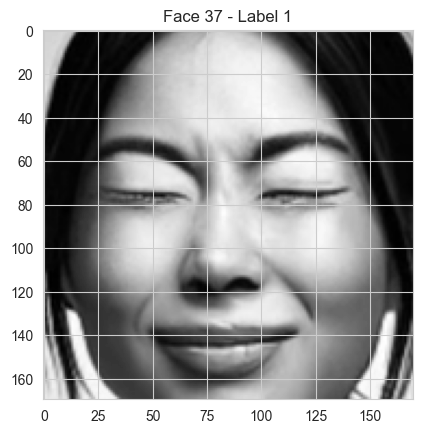

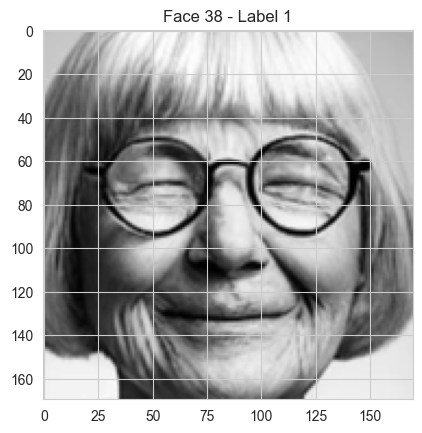

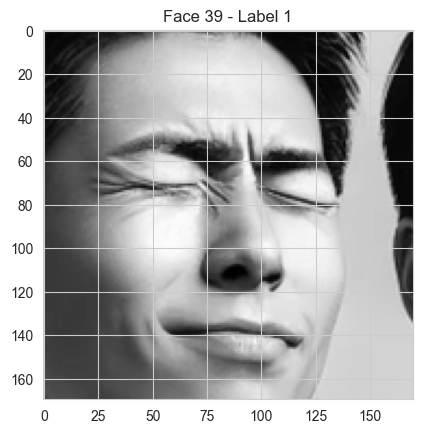

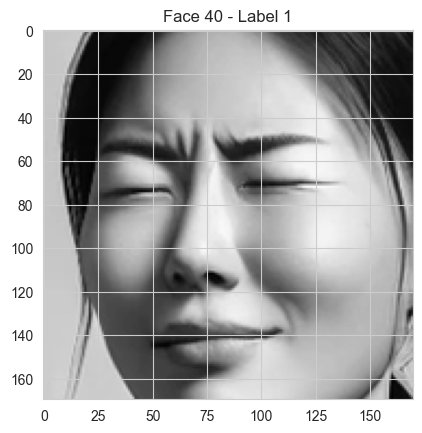

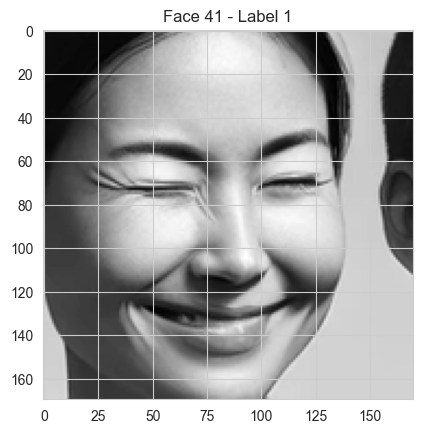

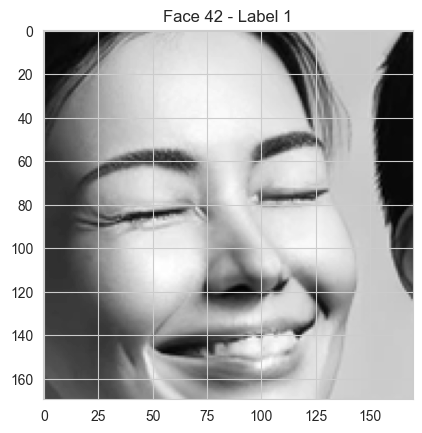

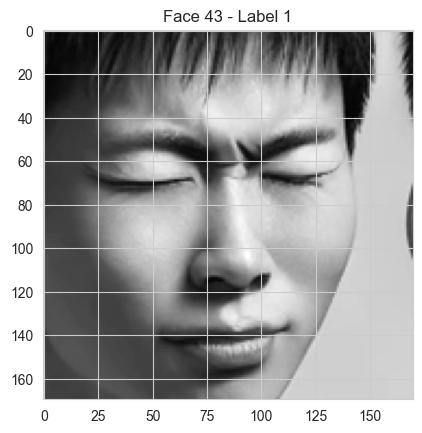

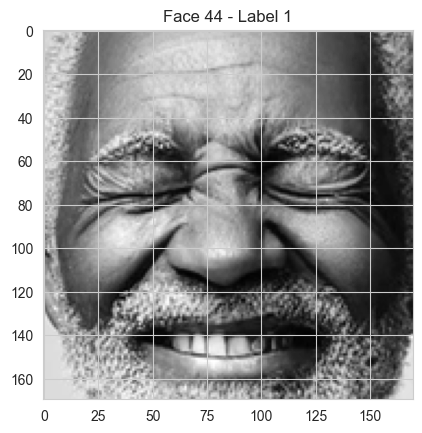

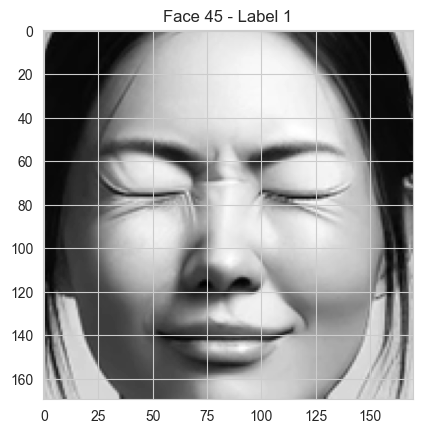

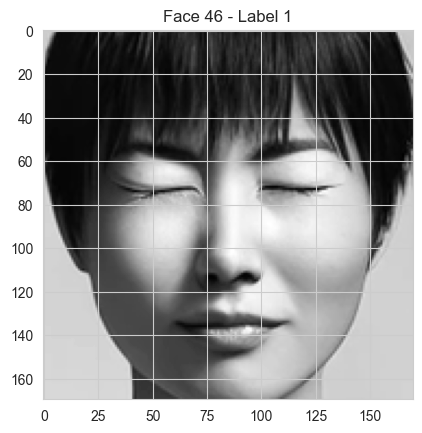

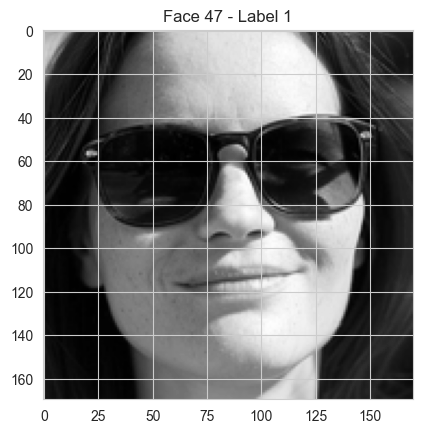

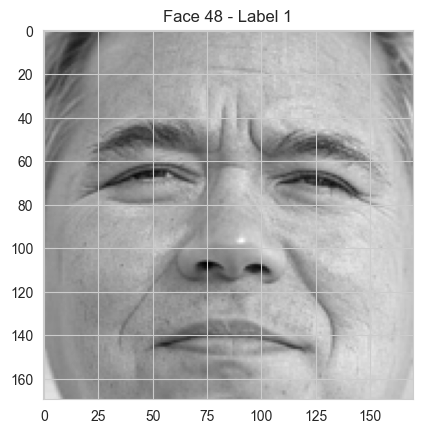

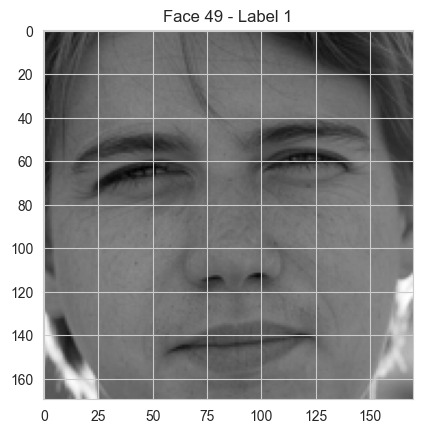

Label Counts:
Y
0    81
1    58
Name: count, dtype: int64

Label Percentages (%):
Y
0    58.273381
1    41.726619
Name: proportion, dtype: float64


C:\Users\Nick DiSalvo\AppData\Local\Temp\ipykernel_11284\3669383214.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Y', data=df, palette='viridis')


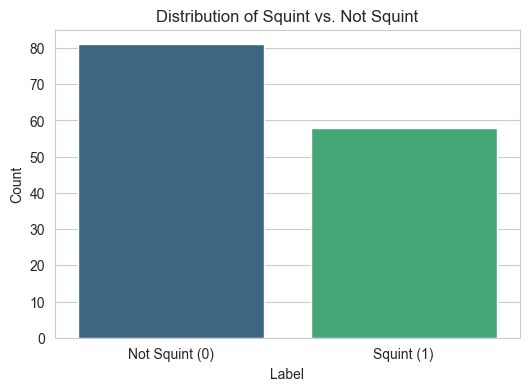

In [43]:
def remove_no_face_rows(df):
    """
    Removes rows from df where 'raw' is None, empty, or doesn't match expected shape (170, 170).
    Returns a filtered copy of df.
    """
    def has_valid_face(arr):
        # Must not be None
        if arr is None:
            return False
        
        # Must be at least 2D
        if arr.ndim != 2:
            return False
        
        # Must be the right shape for a 170x170 grayscale face
        if arr.shape != (170, 170):
            return False
        
        # Optionally, skip arrays of all zeros (completely black)
        if arr.sum() == 0:
            return False
        
        return True

    mask = df['raw'].apply(has_valid_face)
    df_filtered = df[mask].copy()
    removed = len(df) - len(df_filtered)
    print(f"Removed {removed} rows that do not contain a valid face.")
    return df_filtered

def load_face_data():
    # Example directory path
    #directory = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/face-squint'
    directory = 'face-squint'
    
    dict_obj = process_directory(directory)

    if len(dict_obj['X']) > 0:
        df = pd.DataFrame({
            'X': list(dict_obj['X']),    # flattened, padded arrays
            'Y': dict_obj['Y'],          # labels
            'raw': list(dict_obj['raw']) # each is a 2D 170x170
        })
        
        print(f"Total faces before cleaning: {len(df)}")
        
        # Clean out rows that do not actually contain a face
        df = remove_no_face_rows(df)
        
        print(f"Total faces after cleaning: {len(df)}")
        print(df.head())
        
        # View some images (optional - might want to check if any data is left)
        if not df.empty:
            # Create a "dict_obj" style structure so `view_images` can still work
            cleaned_dict_obj = {
                'raw': list(df['raw']),
                'Y': df['Y'].values
            }
            view_images(cleaned_dict_obj, 50)
            plot_label_distribution(df)
        
        return df
    else:
        print("No data to display.")
        return

faces=load_face_data()

In [44]:
def process_grok_faces():
    """Process grok_data and return DataFrame in same format as existing faces"""
    total_data = {'X': [], 'Y': [], 'raw': []}
    
    # Process squinting (1) and non_squinting (0) directories
    for label, subdir in [(1, 'squinting'), (0, 'non_squinting')]:
        directory = os.path.join('grok_data', subdir)
        
        for filename in os.listdir(directory):
            if filename.startswith('.') or not (filename.lower().endswith(('.png', '.jpg', '.jpeg'))):
                continue
            
            full_path = os.path.join(directory, filename)
            try:
                # Direct image processing without face detection
                img = Image.open(full_path)
                # Resize to match expected dimensions
                img = img.resize((170, 170), Image.Resampling.LANCZOS)
                face_gray = img.convert('L')
                face_raw = np.array(face_gray)
                face_flattened = face_raw.flatten()
                
                total_data['X'].append(face_flattened)
                total_data['Y'].append(label)
                total_data['raw'].append(face_raw)
            
            except IOError:
                print(f"Cannot open image file: {filename}")
    
    grok_df = pd.DataFrame({
        'X': total_data['X'],
        'Y': total_data['Y'],
        'raw': total_data['raw']
    })
    return grok_df

# Process grok data and combine with existing faces
grok_df = process_grok_faces()
faces = pd.concat([faces, grok_df], ignore_index=True)
print(f"Added {len(grok_df)} faces from grok_data")
print(f"New total: {len(faces)} faces")

Added 338 faces from grok_data
New total: 477 faces


In [45]:
faces.head()

X  Y  \
0  [84.0, 78.0, 79.0, 80.0, 79.0, 83.0, 82.0, 84....  1   
1  [143.0, 146.0, 149.0, 151.0, 156.0, 157.0, 157...  1   
2  [42.0, 48.0, 49.0, 44.0, 39.0, 52.0, 70.0, 67....  1   
3  [246.0, 246.0, 246.0, 246.0, 246.0, 246.0, 246...  1   
4  [44.0, 42.0, 46.0, 53.0, 62.0, 64.0, 61.0, 58....  1   

                                                 raw  
0  [[84, 78, 79, 80, 79, 83, 82, 84, 85, 85, 84, ...  
1  [[143, 146, 149, 151, 156, 157, 157, 156, 147,...  
2  [[42, 48, 49, 44, 39, 52, 70, 67, 45, 31, 23, ...  
3  [[246, 246, 246, 246, 246, 246, 246, 245, 244,...  
4  [[44, 42, 46, 53, 62, 64, 61, 58, 50, 41, 48, ...

# creating training, test and validate datasets

In [47]:
# ------------------------------------------------------------------------------------
# Below is the part where we create train, validation, and test splits from the DataFrame
# ------------------------------------------------------------------------------------

def create_splits(faces, test_ratio=0.2, val_ratio=0.1, random_seed=42):
    """
    Given a DataFrame 'faces', split into train, val, test sets.
    
    test_ratio: fraction of the data to be held out for testing
    val_ratio: fraction of the *remaining* data to be used for validation
    random_seed: for reproducibility
    """
    # 1. Split off the test set first
    df_trainval, df_test = train_test_split(
        faces,
        test_size=test_ratio,
        random_state=random_seed,
        shuffle=True,
        stratify=faces['Y']  # optional, if you want stratified splits by label
    )
    
    # 2. Of what's left (trainval), split out the validation set
    #    We want val_ratio *of the trainval set*.
    #    For example, if test_ratio=0.2, we have 80% left,
    #    we can do val_ratio=0.1 of the original => 0.1 / 0.8 = 0.125
    #    or you can interpret val_ratio as a fraction of the entire dataset.
    #    Here we'll assume val_ratio is the fraction of *the original dataset*,
    #    so we convert it to fraction of trainval via `val_ratio / (1 - test_ratio)`.
    relative_val_ratio = val_ratio / (1 - test_ratio)  # fraction of trainval
    df_train, df_val = train_test_split(
        df_trainval,
        test_size=relative_val_ratio,
        random_state=random_seed,
        shuffle=True,
        stratify=df_trainval['Y']
    )
    
    return df_train, df_val, df_test

df_faces = faces
if not df_faces.empty:
    # Create train/val/test splits: 70% train, 10% val, 20% test (example)
    # => test_ratio=0.2, val_ratio=0.1
    # This means:
    #   test = 20% of total
    #   val = 10% of total
    #   train = 70% of total
    df_train, df_val, df_test = create_splits(df_faces, test_ratio=0.2, val_ratio=0.1)
    
    print("\nSplit sizes:")
    print("Train set:", len(df_train))
    print("Val set:", len(df_val))
    print("Test set:", len(df_test))
    
    # OPTIONAL: If you want them as arrays
    # Convert flattened features (X) to a 2D numpy array
    X_train = np.stack(df_train['X'].values)
    y_train = df_train['Y'].values
    
    X_val = np.stack(df_val['X'].values)
    y_val = df_val['Y'].values
    
    X_test = np.stack(df_test['X'].values)
    y_test = df_test['Y'].values

    X_train = X_train.reshape(-1, 170, 170, 1)
    X_val = X_val.reshape(-1, 170, 170, 1)
    X_test = X_test.reshape(-1, 170, 170, 1)

    
    # Now you have train, val, test in DataFrame form (df_train, df_val, df_test)
    # or in array form (X_train, y_train, X_val, y_val, X_test, y_test).
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape:   {X_val.shape},   y_val shape:   {y_val.shape}")
    print(f"X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")
else:
    print("No faces found. Exiting.")
      


Split sizes:
Train set: 333
Val set: 48
Test set: 96
X_train shape: (333, 170, 170, 1), y_train shape: (333,)
X_val shape:   (48, 170, 170, 1),   y_val shape:   (48,)
X_test shape:  (96, 170, 170, 1),  y_test shape:  (96,)


# setting up the model, training the model, and evaluating it


In [ ]:

def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze and Excitation block."""
    channels = int(input_tensor.shape[-1])
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', use_bias=False)(se)
    return multiply([input_tensor, se])

def create_model_with_attention(input_shape, num_classes):
    # Define input
    inputs = tf.keras.Input(shape=input_shape)

    # Conv block 1
    x = Conv2D(32, (3,3), activation='relu', padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)   # Directly call the SE function
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # Conv block 2
    x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x) 
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # Classifier
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build the Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_model(input_shape, num_classes):
    """
    Builds a CNN for face classification.
    
    Args:
        input_shape (tuple): Shape of a single input image, e.g. (170, 170, 1) for grayscale
        num_classes (int): Number of output classes (e.g., 2 if squint vs. not squint)

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

def train_model(model, X_train, y_train, validation_data=None, epochs=20):
    """
    Trains the CNN model using X_train, y_train, and optionally validation_data=(X_val, y_val).
    
    Args:
        model (keras.Model): Compiled Keras model.
        X_train: Training data (NumPy array or a generator-like object).
        y_train: Training labels (NumPy array). If X_train is a generator, y_train can be None.
        validation_data (tuple or generator): Either (X_val, y_val) if using NumPy arrays,
                                             or a generator-like object with 'samples' and 'batch_size'.
        epochs (int): Number of epochs to train.

    Returns:
        history: Keras History object with training curves.
    """
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]

    # Figure out steps_per_epoch if X_train is a generator-like object
    if hasattr(X_train, 'samples') and hasattr(X_train, 'batch_size'):
        steps_per_epoch = X_train.samples // X_train.batch_size
    else:
        steps_per_epoch = None

    # Figure out validation_steps if validation_data is also a generator
    validation_steps = None
    if validation_data is not None:
        if hasattr(validation_data, 'samples') and hasattr(validation_data, 'batch_size'):
            validation_steps = validation_data.samples // validation_data.batch_size


    # One-hot encode the labels (which are 0 or 1)
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=2)
    y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes=2)
    y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes=2)


    # Now fit the model
    # If X_train, y_train are NumPy arrays, this works
    # If X_train is a generator, it expects y_train=None (typical for generators),
    #   but we allow it here in case user wants to pass it anyway.
    history = model.fit(
        X_train, 
        y_train_oh, 
        validation_data=(X_val, y_val_oh),
        epochs=64
    )
    
    return history

def evaluate_model(model, test_data):
    """
    Evaluates the model on test_data and prints the loss & accuracy.
    
    Args:
        model (keras.Model): Trained Keras model.
        test_data: Test dataset (ImageDataGenerator, tf.data.Dataset, or (x_test, y_test)).
    """
    # If it's an ImageDataGenerator, we can do steps = test_data.samples // test_data.batch_size
    # If it's tf.data or NumPy arrays, you can omit steps.
    
    steps = None
    if hasattr(test_data, "samples") and hasattr(test_data, "batch_size"):
        steps = test_data.samples // test_data.batch_size
    
    scores = model.evaluate(test_data, steps=steps)
    print(f"Test Loss: {scores[0]}")
    print(f"Test Accuracy: {scores[1]}")

#
# EXAMPLE USAGE (assuming you have train_data, val_data, test_data):
#
model = create_model_with_attention(input_shape=(170,170,1), num_classes=2)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = train_model(model, X_train, y_train, validation_data=(X_val, y_val))
#evaluate_model(model, df_test)
#


In [ ]:
model.summary()

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves
    from a Keras History object.
    """
    # Use a Seaborn style/theme for a "fancy" look
    sns.set_style("darkgrid") 

    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create an array of epoch indices (1-based)
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots: Accuracy & Loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Accuracy Plot ---
    axes[0].plot(epochs, acc, label='Training Accuracy', marker='o', color='blue')
    axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='orange')
    axes[0].set_title('Training & Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    
    # --- Loss Plot ---
    axes[1].plot(epochs, loss, label='Training Loss', marker='o', color='red')
    axes[1].plot(epochs, val_loss, label='Validation Loss', marker='o', color='green')
    axes[1].set_title('Training & Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()

    # Add a main title for the entire figure
    fig.suptitle('Model Performance Over Epochs', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)